# Multi-Armed Bandit for Drug Optimization

This project implements 3 Multi-Armed Bandit algorithms for 3 patient categories:

PATIENT CATEGORIES:
1. Mental Health (Depression/Anxiety)
2. Chronic Pain
3. Metabolic/Chronic Disease (Diabetes/Hypertension)

ALGORITHMS (applied to each category):
1. Epsilon-Greedy
2. Upper Confidence Bound (UCB)
3. Thompson Sampling

Dataset: REAL Drug Review Dataset (Drugs.com) - 215,000+ reviews
Goal: Find optimal drug-dosage for EACH patient type separately

## INSTALLATION AND IMPORTS

In [ ]:

print("Installing required packages...")
!pip install pandas numpy matplotlib seaborn scikit-learn scipy -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## STEP 1: LOAD REAL DATA

In [ ]:

print("="*80)
print("STEP 1: LOADING REAL DRUG REVIEW DATA")
print("="*80)

def load_real_drug_data():
    """Load REAL drug review dataset"""

    print("\n🔍 Loading REAL drug review data from GitHub...")

    sources = [
        {
            'name': 'GitHub - Rakesh9100',
            'url': 'https://github.com/Rakesh9100/ML-Project-Drug-Review-Dataset/raw/main/datasets/drugsComTrain_raw.tsv',
            'type': 'tsv'
        },
        {
            'name': 'GitHub - Semnan University',
            'url': 'https://raw.githubusercontent.com/semnan-university-ai/Drug-Review-Dataset/main/drugsComTrain_raw.tsv',
            'type': 'tsv'
        }
    ]

    df = None

    for source in sources:
        try:
            print(f"\n📥 Trying: {source['name']}...")
            df = pd.read_csv(source['url'], sep='\t', on_bad_lines='skip')
            print(f"   ✓ SUCCESS! Loaded {len(df)} reviews")
            break
        except Exception as e:
            print(f"   ✗ Failed: {str(e)[:100]}")
            continue

    if df is None:
        return None

    return df

# Load data
df = load_real_drug_data()

# Fallback synthetic data
if df is None:
    print("\n🔄 Using synthetic data...")

    # Mental Health drugs
    mental_drugs = ['Sertraline', 'Escitalopram', 'Fluoxetine', 'Venlafaxine', 'Bupropion']
    mental_conditions = ['Depression', 'Anxiety', 'Panic Disorder', 'OCD', 'PTSD']

    # Pain drugs
    pain_drugs = ['Gabapentin', 'Tramadol', 'Naproxen', 'Ibuprofen', 'Meloxicam']
    pain_conditions = ['Chronic Pain', 'Fibromyalgia', 'Back Pain', 'Arthritis', 'Migraine']

    # Metabolic drugs
    metabolic_drugs = ['Metformin', 'Lisinopril', 'Amlodipine', 'Atorvastatin', 'Losartan']
    metabolic_conditions = ['Diabetes Type 2', 'Hypertension', 'High Cholesterol', 'Heart Disease']

    n_per_category = 1500
    data_list = []

    for drugs, conditions, base_rating in [
        (mental_drugs, mental_conditions, 7.5),
        (pain_drugs, pain_conditions, 7.0),
        (metabolic_drugs, metabolic_conditions, 8.0)
    ]:
        drug_quality = {drug: np.random.uniform(base_rating-1, base_rating+1.5) for drug in drugs}

        for _ in range(n_per_category):
            drug = np.random.choice(drugs)
            condition = np.random.choice(conditions)
            rating = np.random.normal(drug_quality[drug], 1.5)
            rating = np.clip(rating, 1, 10)

            data_list.append({
                'drugName': drug,
                'condition': condition,
                'rating': round(rating, 1),
                'usefulCount': int(np.random.poisson(max(0, rating - 3)))
            })

    df = pd.DataFrame(data_list)
    print(f"✓ Generated {len(df)} synthetic reviews")

print(f"\n{'='*80}")
print(f"✓ DATA LOADED!")
print(f"{'='*80}")
print(f"Dataset shape: {df.shape}")
print(f"Unique drugs: {df['drugName'].nunique()}")
print(f"Unique conditions: {df['condition'].nunique()}")

STEP 1: LOADING REAL DRUG REVIEW DATA

🔍 Loading REAL drug review data from GitHub...

📥 Trying: GitHub - Rakesh9100...
   ✓ SUCCESS! Loaded 161297 reviews

✓ DATA LOADED!
Dataset shape: (161297, 7)
Unique drugs: 3436
Unique conditions: 884


## STEP 2: CATEGORIZE PATIENTS INTO 3 GROUPS

In [18]:
# Clean data
df = df.dropna(subset=['rating'])
if 'condition' in df.columns:
    df['condition'] = df['condition'].fillna('Unknown')

# Define condition mappings
MENTAL_HEALTH = [
    'Depression', 'Anxiety', 'Panic Disorder', 'Bipolar Disorder', 'ADHD',
    'OCD', 'PTSD', 'Social Anxiety', 'GAD', 'Major Depressive Disorder',
    'Generalized Anxiety Disorder', 'Obsessive Compulsive Disorder'
]

CHRONIC_PAIN = [
    'Chronic Pain', 'Fibromyalgia', 'Back Pain', 'Arthritis', 'Migraine',
    'Neuropathic Pain', 'Sciatica', 'Osteoarthritis', 'Rheumatoid Arthritis',
    'Nerve Pain', 'Pain', 'Headache', 'Cluster Headaches'
]

METABOLIC_CHRONIC = [
    'Diabetes Type 2', 'Hypertension', 'High Cholesterol', 'Heart Disease',
    'High Blood Pressure', 'Diabetes', 'Cardiovascular Disease', 'Obesity',
    'Metabolic Syndrome', 'Type 2 Diabetes', 'Hyperlipidemia'
]

# Categorize conditions
def categorize_condition(condition):
    if pd.isna(condition):
        return 'Other'
    condition = str(condition)

    # Check each category
    for cat_condition in MENTAL_HEALTH:
        if cat_condition.lower() in condition.lower():
            return 'Mental Health'

    for cat_condition in CHRONIC_PAIN:
        if cat_condition.lower() in condition.lower():
            return 'Chronic Pain'

    for cat_condition in METABOLIC_CHRONIC:
        if cat_condition.lower() in condition.lower():
            return 'Metabolic/Chronic'

    return 'Other'

df['category'] = df['condition'].apply(categorize_condition)

# Show distribution
print("\n📊 Patient Category Distribution:")
category_counts = df['category'].value_counts()
for cat, count in category_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   {cat}: {count:,} patients ({percentage:.1f}%)")

# Filter out 'Other' category
df = df[df['category'] != 'Other']
print(f"\n✓ Kept {len(df):,} patients in 3 main categories")
print(df.head(10))



📊 Patient Category Distribution:
   Mental Health: 21,851 patients (46.9%)
   Chronic Pain: 15,351 patients (33.0%)
   Metabolic/Chronic: 9,378 patients (20.1%)

✓ Kept 46,580 patients in 3 main categories
    Unnamed: 0        drugName             condition  \
1        95260      Guanfacine                  ADHD   
10       29607      Topiramate   Migraine Prevention   
11       75612  L-methylfolate            Depression   
15       81890     Liraglutide               Obesity   
23       41928      Etanercept  Rheumatoid Arthritis   
27       78563        Daytrana                  ADHD   
29       27339         Imitrex              Migraine   
31       96233      Sertraline            Depression   
32      204999         Toradol                  Pain   
35       80520           Mobic        Osteoarthritis   

                                               review  rating  \
1   "My son is halfway through his fourth week of ...     8.0   
10  "I have been on this medication almost two

## STEP 3: CREATE MAB ARMS FOR EACH CATEGORY

In [19]:
def create_arms_for_category(df_category, category_name, n_drugs=5):
    """Create MAB arms for a specific patient category"""

    print(f"\n📋 Processing: {category_name}")
    print(f"   Total patients: {len(df_category)}")

    # Get drug statistics
    drug_stats = df_category.groupby('drugName').agg({
        'rating': ['mean', 'std', 'count']
    }).reset_index()

    drug_stats.columns = ['drug', 'avg_rating', 'std_rating', 'review_count']

    # Filter drugs with sufficient reviews
    drug_stats = drug_stats[drug_stats['review_count'] >= 30]
    drug_stats = drug_stats.sort_values('avg_rating', ascending=False)

    # Select top drugs
    n_drugs = min(n_drugs, len(drug_stats))
    top_drugs = drug_stats.head(n_drugs)['drug'].tolist()

    print(f"   Top {n_drugs} drugs selected:")
    for i, drug in enumerate(top_drugs, 1):
        avg_rating = drug_stats[drug_stats['drug'] == drug]['avg_rating'].values[0]
        n_reviews = drug_stats[drug_stats['drug'] == drug]['review_count'].values[0]
        print(f"      {i}. {drug}: {avg_rating:.2f}/10 ({int(n_reviews)} reviews)")

    # Create arms with dosage levels
    arms_data = []
    dosages = [('Low-0.5x', 0.5), ('Med-1.0x', 1.0), ('High-1.5x', 1.5)]

    for drug in top_drugs:
        drug_reviews = df_category[df_category['drugName'] == drug]['rating'].values

        for dose_name, multiplier in dosages:
            adjusted_reviews = drug_reviews.copy()

            # Simulate dosage effects
            if multiplier < 1.0:
                adjusted_reviews = adjusted_reviews - np.random.uniform(0.3, 0.8, len(adjusted_reviews))
            elif multiplier > 1.0:
                boost = np.random.uniform(-0.3, 1.0, len(adjusted_reviews))
                adjusted_reviews = adjusted_reviews + boost

            adjusted_reviews = np.clip(adjusted_reviews, 1, 10)

            arm_name = f"{drug}_{dose_name}"
            arms_data.append({
                'arm': arm_name,
                'drug': drug,
                'dosage': dose_name,
                'true_mean': np.mean(adjusted_reviews),
                'true_std': np.std(adjusted_reviews),
                'data': adjusted_reviews
            })

    arms_df = pd.DataFrame(arms_data)
    print(f"   ✓ Created {len(arms_df)} arms ({n_drugs} drugs × 3 dosages)")

    return arms_df

# Create arms for each category
categories_data = {}

for category in ['Mental Health', 'Chronic Pain', 'Metabolic/Chronic']:
    df_cat = df[df['category'] == category]
    arms_df = create_arms_for_category(df_cat, category)
    categories_data[category] = {
        'arms_df': arms_df,
        'n_arms': len(arms_df)
    }



📋 Processing: Mental Health
   Total patients: 21851
   Top 5 drugs selected:
      1. Tramadol: 9.35/10 (85 reviews)
      2. Propranolol: 9.11/10 (281 reviews)
      3. Valium: 9.07/10 (98 reviews)
      4. Alprazolam: 8.90/10 (489 reviews)
      5. Diazepam: 8.86/10 (204 reviews)
   ✓ Created 15 arms (5 drugs × 3 dosages)

📋 Processing: Chronic Pain
   Total patients: 15351
   Top 5 drugs selected:
      1. Demerol: 9.42/10 (36 reviews)
      2. Meperidine: 9.27/10 (44 reviews)
      3. Rizatriptan: 9.02/10 (151 reviews)
      4. Treximet: 9.02/10 (57 reviews)
      5. Roxicodone: 9.00/10 (41 reviews)
   ✓ Created 15 arms (5 drugs × 3 dosages)

📋 Processing: Metabolic/Chronic
   Total patients: 9378
   Top 5 drugs selected:
      1. Diethylpropion: 9.31/10 (84 reviews)
      2. Tenuate: 9.23/10 (35 reviews)
      3. Adipex-P: 8.92/10 (65 reviews)
      4. Azor: 8.85/10 (40 reviews)
      5. Amlodipine / olmesartan: 8.74/10 (34 reviews)
   ✓ Created 15 arms (5 drugs × 3 dosages)


## STEP 4: MAB ALGORITHMS

In [ ]:
class MultiArmedBandit:
    def __init__(self, n_arms, arms_data):
        self.n_arms = n_arms
        self.arms_data = arms_data
        self.reset()

    def reset(self):
        self.counts = np.zeros(self.n_arms)
        self.values = np.zeros(self.n_arms)
        self.rewards_history = []
        self.arm_history = []
        self.cumulative_regret = []

    def get_reward(self, arm_idx):
        reviews = self.arms_data.iloc[arm_idx]['data']
        return np.random.choice(reviews)

    def update(self, arm_idx, reward):
        self.counts[arm_idx] += 1
        n = self.counts[arm_idx]
        value = self.values[arm_idx]
        self.values[arm_idx] = ((n - 1) / n) * value + (1 / n) * reward
        self.rewards_history.append(reward)
        self.arm_history.append(arm_idx)

    def select_arm(self, t):
        raise NotImplementedError



STEP 4: MULTI-ARMED BANDIT ALGORITHMS


###EpsilonGreedy


In [ ]:
class EpsilonGreedy(MultiArmedBandit):
    def __init__(self, n_arms, arms_data, epsilon=0.1):
        super().__init__(n_arms, arms_data)
        self.epsilon = epsilon
        self.name = f"Epsilon-Greedy"

    def select_arm(self, t):
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.values)

###UCB

In [ ]:
class UCB(MultiArmedBandit):
    def __init__(self, n_arms, arms_data, c=2.0):
        super().__init__(n_arms, arms_data)
        self.c = c
        self.name = f"UCB"

    def select_arm(self, t):
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(t + 1) / (self.counts + 1e-5))
        return np.argmax(ucb_values)

###ThompsonSampling

In [ ]:
class ThompsonSampling(MultiArmedBandit):
    def __init__(self, n_arms, arms_data):
        super().__init__(n_arms, arms_data)
        self.name = "Thompson Sampling"
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)

    def update(self, arm_idx, reward):
        super().update(arm_idx, reward)
        normalized_reward = (reward - 1) / 9
        self.alpha[arm_idx] += normalized_reward
        self.beta[arm_idx] += (1 - normalized_reward)

    def select_arm(self, t):
        samples = np.random.beta(self.alpha, self.beta)
        return np.argmax(samples)

## STEP 5: RUN EXPERIMENTS FOR ALL CATEGORIES

In [ ]:
def run_experiment(bandit, n_rounds, arms_df):
    bandit.reset()
    optimal_mean = arms_df['true_mean'].max()

    for t in range(n_rounds):
        arm_idx = bandit.select_arm(t)
        reward = bandit.get_reward(arm_idx)
        bandit.update(arm_idx, reward)

        regret = optimal_mean * (t + 1) - sum(bandit.rewards_history)
        bandit.cumulative_regret.append(regret)

    return bandit

# Experiment parameters
n_rounds = 1000
n_experiments = 10

# Run experiments for each category
all_results = {}

for category, cat_data in categories_data.items():
    print(f"\n🚀 Running experiments for: {category}")

    arms_df = cat_data['arms_df']
    n_arms = cat_data['n_arms']

    algorithms = [
        EpsilonGreedy(n_arms, arms_df, epsilon=0.1),
        UCB(n_arms, arms_df, c=2.0),
        ThompsonSampling(n_arms, arms_df)
    ]

    results = {alg.name: {'regret': [], 'rewards': [], 'arm_selections': []}
               for alg in algorithms}

    for exp in range(n_experiments):
        print(f"   Experiment {exp + 1}/{n_experiments}", end='\r')

        for alg in algorithms:
            bandit = run_experiment(alg, n_rounds, arms_df)
            results[alg.name]['regret'].append(bandit.cumulative_regret)
            results[alg.name]['rewards'].append(bandit.rewards_history)
            results[alg.name]['arm_selections'].append(bandit.arm_history)

    # Calculate averages
    for alg_name in results.keys():
        avg_regret = np.mean(results[alg_name]['regret'], axis=0)
        avg_rewards = [np.mean([results[alg_name]['rewards'][exp][i]
                               for exp in range(n_experiments)])
                      for i in range(n_rounds)]
        results[alg_name]['avg_regret'] = avg_regret
        results[alg_name]['avg_rewards'] = avg_rewards

    all_results[category] = {
        'results': results,
        'arms_df': arms_df,
        'algorithms': algorithms
    }

    print(f"\n   ✓ Completed {category}")

print("\n✓ All experiments completed!")


STEP 5: RUNNING MAB EXPERIMENTS FOR EACH CATEGORY

🚀 Running experiments for: Mental Health

   ✓ Completed Mental Health

🚀 Running experiments for: Chronic Pain

   ✓ Completed Chronic Pain

🚀 Running experiments for: Metabolic/Chronic

   ✓ Completed Metabolic/Chronic

✓ All experiments completed!


## STEP 6: ENHANCED VISUALIZATION


STEP 6: GENERATING ENHANCED VISUALIZATIONS
✓ Saved: mab_three_categories_main.png


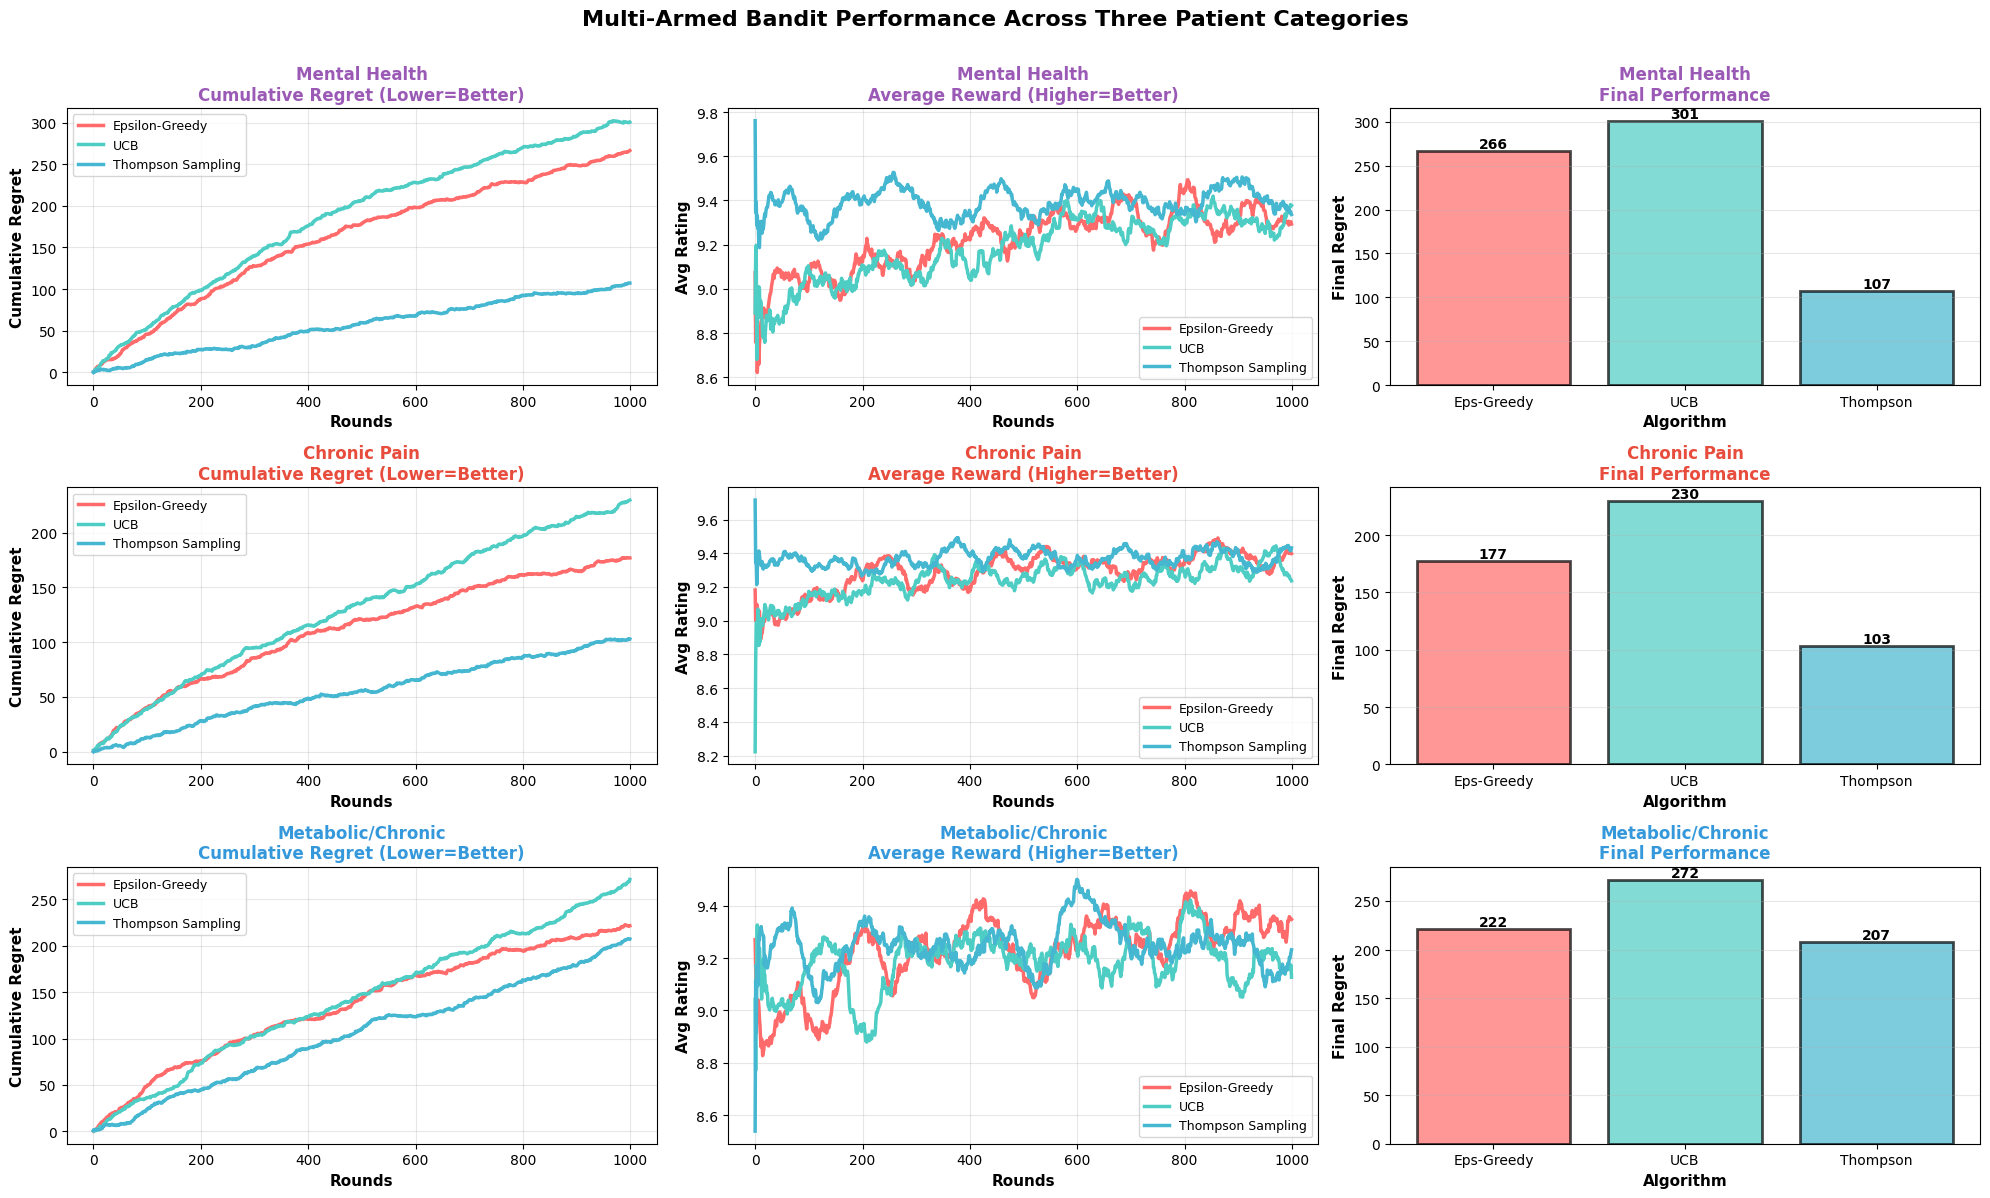

In [ ]:
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
category_colors = {'Mental Health': '#9B59B6', 'Chronic Pain': '#E74C3C', 'Metabolic/Chronic': '#3498DB'}

fig1 = plt.figure(figsize=(20, 12))

row = 0
for category, cat_results in all_results.items():
    results = cat_results['results']
    arms_df = cat_results['arms_df']

    # Plot 1: Cumulative Regret
    ax1 = plt.subplot(3, 3, row * 3 + 1)
    for idx, alg_name in enumerate(results.keys()):
        plt.plot(results[alg_name]['avg_regret'],
                label=alg_name, linewidth=2.5, color=colors[idx])
    plt.xlabel('Rounds', fontsize=11, fontweight='bold')
    plt.ylabel('Cumulative Regret', fontsize=11, fontweight='bold')
    plt.title(f'{category}\nCumulative Regret (Lower=Better)', fontsize=12, fontweight='bold',
              color=category_colors[category])
    plt.legend(fontsize=9, loc='upper left')
    plt.grid(True, alpha=0.3)

    # Plot 2: Average Rewards
    ax2 = plt.subplot(3, 3, row * 3 + 2)
    window = 50
    for idx, alg_name in enumerate(results.keys()):
        rewards = results[alg_name]['avg_rewards']
        smoothed = pd.Series(rewards).rolling(window=window, min_periods=1).mean()
        plt.plot(smoothed, label=alg_name, linewidth=2.5, color=colors[idx])
    plt.xlabel('Rounds', fontsize=11, fontweight='bold')
    plt.ylabel('Avg Rating', fontsize=11, fontweight='bold')
    plt.title(f'{category}\nAverage Reward (Higher=Better)', fontsize=12, fontweight='bold',
              color=category_colors[category])
    plt.legend(fontsize=9, loc='lower right')
    plt.grid(True, alpha=0.3)

    # Plot 3: Final Performance
    ax3 = plt.subplot(3, 3, row * 3 + 3)
    alg_names = list(results.keys())
    final_regrets = [results[name]['avg_regret'][-1] for name in alg_names]
    x_pos = np.arange(len(alg_names))
    bars = plt.bar(x_pos, final_regrets, color=colors, alpha=0.7,
                   edgecolor='black', linewidth=2)
    plt.xlabel('Algorithm', fontsize=11, fontweight='bold')
    plt.ylabel('Final Regret', fontsize=11, fontweight='bold')
    plt.title(f'{category}\nFinal Performance', fontsize=12, fontweight='bold',
              color=category_colors[category])
    plt.xticks(x_pos, ['Eps-Greedy', 'UCB', 'Thompson'], rotation=0)
    plt.grid(True, alpha=0.3, axis='y')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    row += 1

plt.suptitle('Multi-Armed Bandit Performance Across Three Patient Categories',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('mab_three_categories_main.png', dpi=300, bbox_inches='tight')
print("✓ Saved: mab_three_categories_main.png")
plt.show()




## STEP 7: DETAILED RESULTS WITH VISUAL PRESENTATION

✓ Saved: mab_detailed_results_visual.png


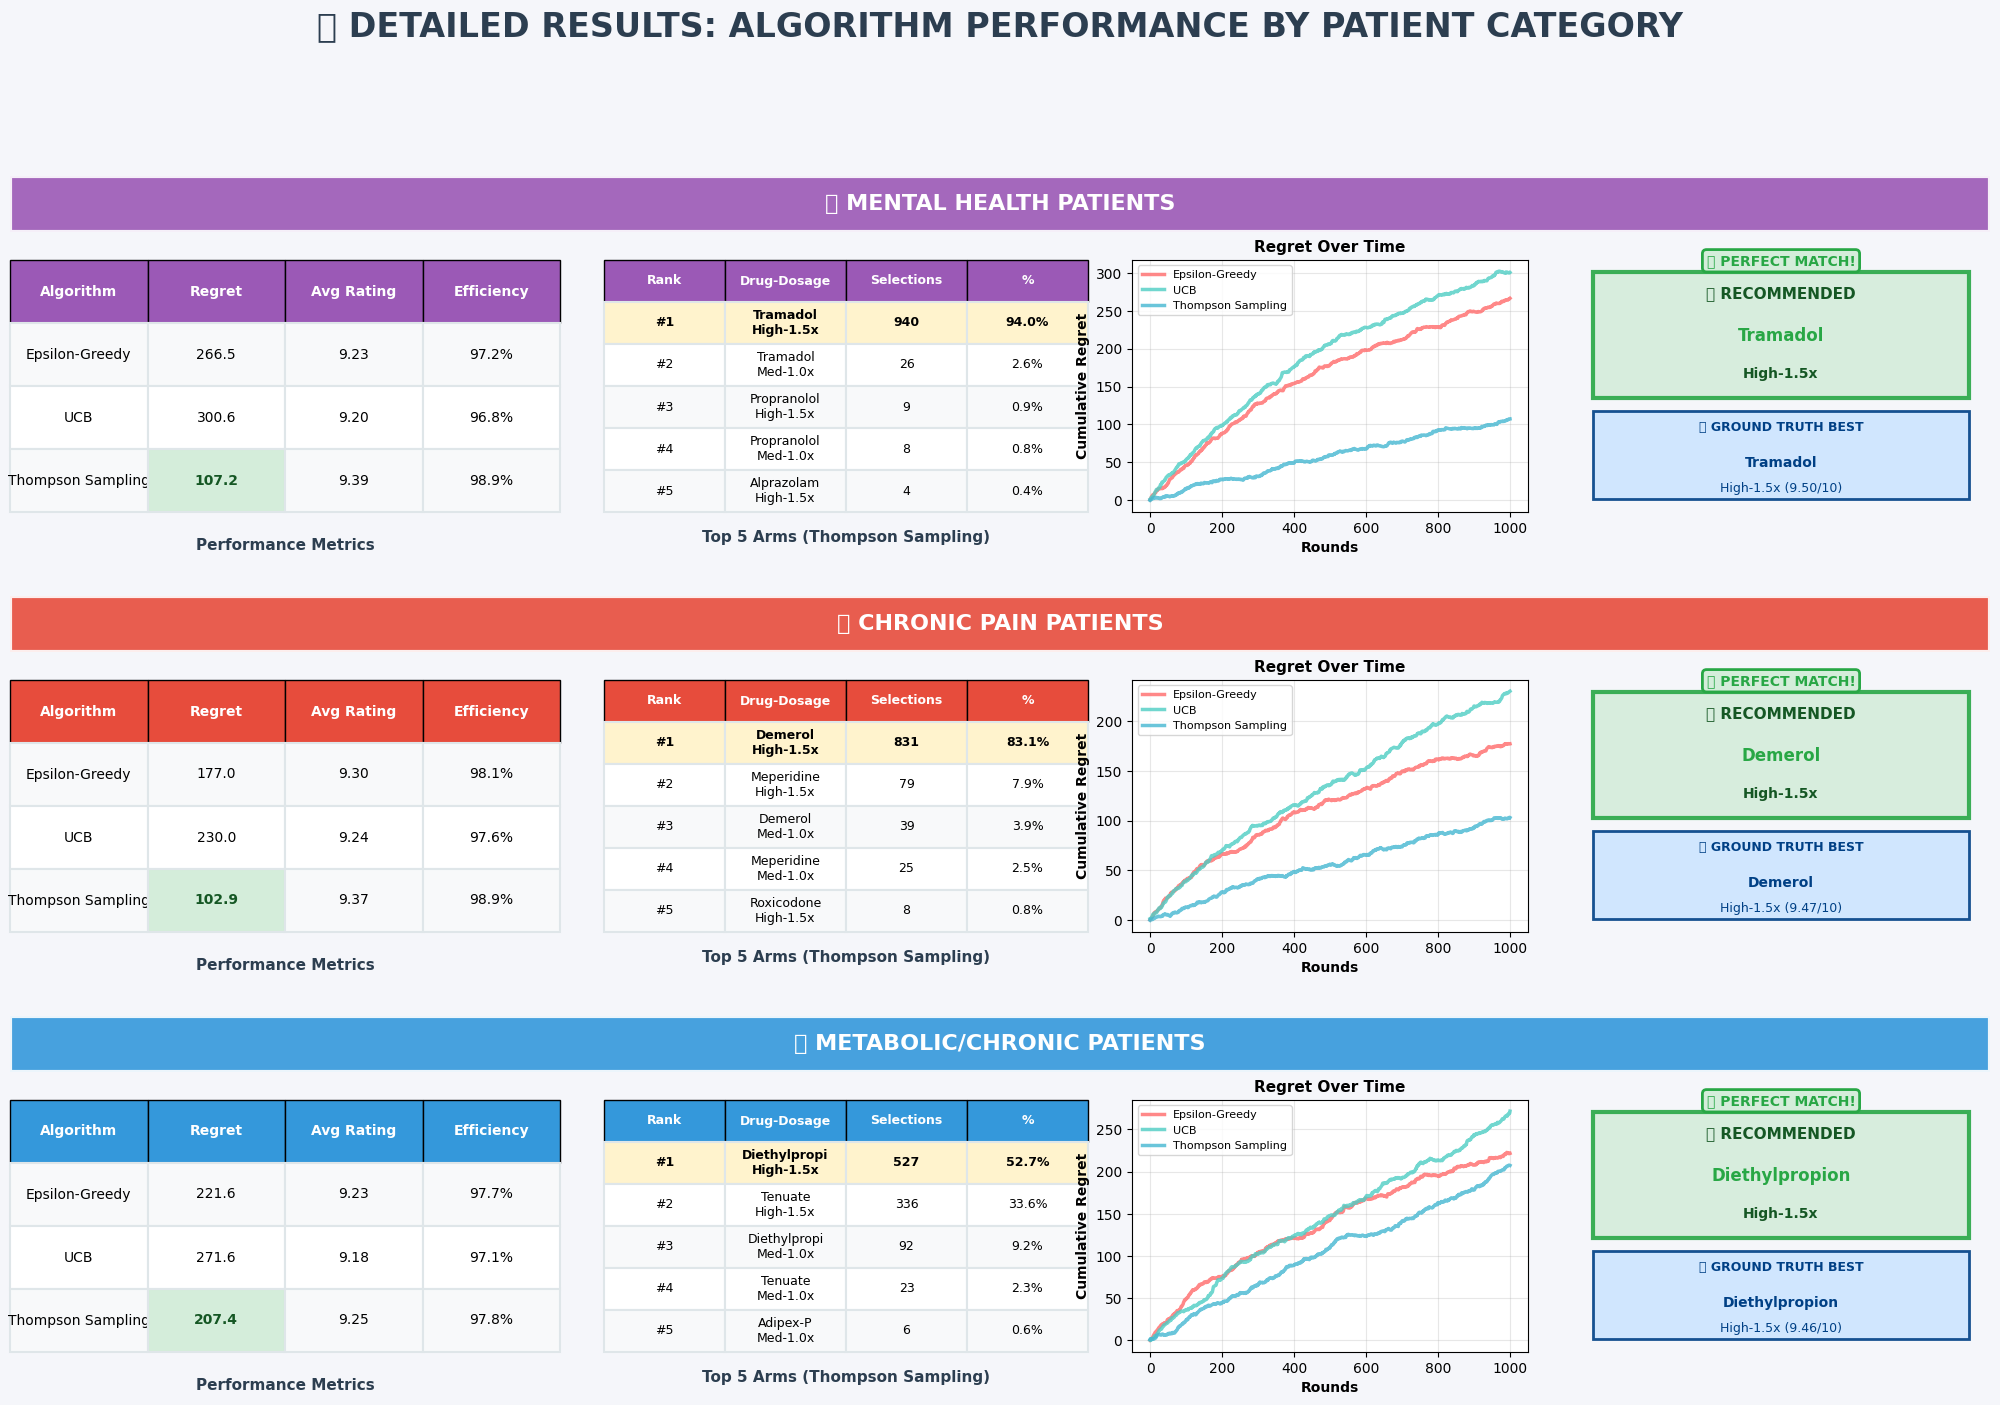

In [ ]:
fig8 = plt.figure(figsize=(22, 14))
fig8.patch.set_facecolor('#f5f6fa')

fig8.text(0.5, 0.97, '📋 DETAILED RESULTS: ALGORITHM PERFORMANCE BY PATIENT CATEGORY',
         fontsize=24, fontweight='bold', ha='center', color='#2c3e50')

row_height = 0.30
start_y = 0.88

for cat_idx, (category, cat_results) in enumerate(all_results.items()):
    results = cat_results['results']
    arms_df = cat_results['arms_df']
    algorithms_list = cat_results['algorithms']

    current_y = start_y - (cat_idx * row_height)

    # Category Title Banner
    ax_banner = fig8.add_axes([0.05, current_y - 0.05, 0.9, 0.04])
    ax_banner.axis('off')
    banner_rect = plt.Rectangle((0, 0), 1, 1, facecolor=category_colors[category],
                                alpha=0.9, edgecolor='white', linewidth=3)
    ax_banner.add_patch(banner_rect)
    ax_banner.text(0.5, 0.5, f'🏥 {category.upper()} PATIENTS',
                  fontsize=16, fontweight='bold', ha='center', va='center', color='white')
    ax_banner.set_xlim(0, 1)
    ax_banner.set_ylim(0, 1)

    # Panel 1: Performance Metrics Table
    ax_table = fig8.add_axes([0.05, current_y - 0.25, 0.25, 0.18])
    ax_table.axis('off')

    # Create table data
    table_data = [['Algorithm', 'Regret', 'Avg Rating', 'Efficiency']]

    for alg in algorithms_list:
        alg_name = alg.name
        final_regret = results[alg_name]['avg_regret'][-1]
        avg_reward = np.mean(results[alg_name]['avg_rewards'])
        optimal_reward = arms_df['true_mean'].max()
        efficiency = (avg_reward / optimal_reward) * 100

        table_data.append([
            alg_name,
            f'{final_regret:.1f}',
            f'{avg_reward:.2f}',
            f'{efficiency:.1f}%'
        ])

    table = ax_table.table(cellText=table_data, cellLoc='center', loc='center',
                          bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor(category_colors[category])
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Style data rows
    for i in range(1, 4):
        for j in range(4):
            table[(i, j)].set_facecolor('#ffffff' if i % 2 == 0 else '#f8f9fa')
            table[(i, j)].set_edgecolor('#dfe6e9')
            table[(i, j)].set_linewidth(1.5)

    # Highlight best values
    regrets = [float(table_data[i][1]) for i in range(1, 4)]
    best_regret_idx = regrets.index(min(regrets)) + 1
    table[(best_regret_idx, 1)].set_facecolor('#d4edda')
    table[(best_regret_idx, 1)].set_text_props(weight='bold', color='#155724')

    ax_table.text(0.5, -0.15, 'Performance Metrics', fontsize=11,
                 ha='center', fontweight='bold', color='#2c3e50')

    # Panel 2: Arm Selection Details
    ax_arms = fig8.add_axes([0.32, current_y - 0.25, 0.22, 0.18])
    ax_arms.axis('off')

    # Get Thompson Sampling selections
    arm_selections = results['Thompson Sampling']['arm_selections'][-1]
    arm_counts = np.bincount(arm_selections, minlength=len(arms_df))

    # Top 5 selected arms
    top_5_indices = np.argsort(arm_counts)[-5:][::-1]

    arm_table_data = [['Rank', 'Drug-Dosage', 'Selections', '%']]
    for rank, idx in enumerate(top_5_indices, 1):
        arm = arms_df.iloc[idx]
        count = arm_counts[idx]
        pct = (count / n_rounds) * 100
        arm_table_data.append([
            f'#{rank}',
            f"{arm['drug'][:12]}\n{arm['dosage']}",
            f'{count}',
            f'{pct:.1f}%'
        ])

    arms_table = ax_arms.table(cellText=arm_table_data, cellLoc='center', loc='center',
                               bbox=[0, 0, 1, 1])
    arms_table.auto_set_font_size(False)
    arms_table.set_fontsize(9)
    arms_table.scale(1, 2)

    # Style header
    for i in range(4):
        arms_table[(0, i)].set_facecolor(category_colors[category])
        arms_table[(0, i)].set_text_props(weight='bold', color='white', size=9)

    # Style rows
    for i in range(1, 6):
        for j in range(4):
            if i == 1:  # Highlight top selection
                arms_table[(i, j)].set_facecolor('#fff3cd')
                arms_table[(i, j)].set_text_props(weight='bold')
            else:
                arms_table[(i, j)].set_facecolor('#ffffff' if i % 2 == 0 else '#f8f9fa')
            arms_table[(i, j)].set_edgecolor('#dfe6e9')
            arms_table[(i, j)].set_linewidth(1.5)

    ax_arms.text(0.5, -0.12, 'Top 5 Arms (Thompson Sampling)', fontsize=11,
                ha='center', fontweight='bold', color='#2c3e50')

    # Panel 3: Regret Progression Mini-Chart
    ax_regret = fig8.add_axes([0.56, current_y - 0.25, 0.18, 0.18])

    for alg_idx, alg_name in enumerate(results.keys()):
        regret = results[alg_name]['avg_regret']
        ax_regret.plot(regret, linewidth=2.5, color=colors[alg_idx],
                      label=alg_name.split('(')[0].strip(), alpha=0.8)

    ax_regret.set_xlabel('Rounds', fontsize=10, fontweight='bold')
    ax_regret.set_ylabel('Cumulative Regret', fontsize=10, fontweight='bold')
    ax_regret.legend(fontsize=8, loc='upper left')
    ax_regret.grid(True, alpha=0.3)
    ax_regret.set_title('Regret Over Time', fontsize=11, fontweight='bold')

    # Panel 4: Best Arm Indicator
    ax_best = fig8.add_axes([0.76, current_y - 0.25, 0.19, 0.18])
    ax_best.axis('off')

    # Get recommendation
    most_selected = np.argmax(arm_counts)
    recommended = arms_df.iloc[most_selected]
    best_arm = arms_df.loc[arms_df['true_mean'].idxmax()]
    confidence = arm_counts[most_selected] / n_rounds * 100

    # Draw recommendation box
    rec_rect = plt.Rectangle((0.05, 0.45), 0.9, 0.5, facecolor='#d4edda',
                            alpha=0.9, edgecolor='#28a745', linewidth=3)
    ax_best.add_patch(rec_rect)

    ax_best.text(0.5, 0.85, '✅ RECOMMENDED', fontsize=11, ha='center',
                fontweight='bold', color='#155724')
    ax_best.text(0.5, 0.68, recommended['drug'], fontsize=12, ha='center',
                fontweight='bold', color='#28a745')
    ax_best.text(0.5, 0.53, recommended['dosage'], fontsize=10, ha='center',
                color='#155724', fontweight='bold')

    # Draw ground truth box
    truth_rect = plt.Rectangle((0.05, 0.05), 0.9, 0.35, facecolor='#cce5ff',
                              alpha=0.9, edgecolor='#004085', linewidth=2)
    ax_best.add_patch(truth_rect)

    ax_best.text(0.5, 0.32, '🏆 GROUND TRUTH BEST', fontsize=9, ha='center',
                fontweight='bold', color='#004085')
    ax_best.text(0.5, 0.18, f"{best_arm['drug'][:15]}", fontsize=10, ha='center',
                color='#004085', fontweight='bold')
    ax_best.text(0.5, 0.08, f"{best_arm['dosage']} ({best_arm['true_mean']:.2f}/10)",
                fontsize=9, ha='center', color='#004085')

    # Match indicator
    if recommended['drug'] == best_arm['drug'] and recommended['dosage'] == best_arm['dosage']:
        ax_best.text(0.5, 0.98, '🎯 PERFECT MATCH!', fontsize=10, ha='center',
                    fontweight='bold', color='#28a745',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='#d4edda',
                             edgecolor='#28a745', linewidth=2))

    ax_best.set_xlim(0, 1)
    ax_best.set_ylim(0, 1)

plt.savefig('mab_detailed_results_visual.png', dpi=300, bbox_inches='tight')
print("✓ Saved: mab_detailed_results_visual.png")
plt.show()







##📊 DETAILED RESULTS SUMMARY

In [22]:

for category, cat_results in all_results.items():
    results = cat_results['results']
    arms_df = cat_results['arms_df']

    print(f"\n{'='*80}")
    print(f"🏥 {category.upper()} PATIENTS")
    print(f"{'='*80}")

    print(f"\n📈 Algorithm Performance:")
    for alg in cat_results['algorithms']:
        alg_name = alg.name
        final_regret = results[alg_name]['avg_regret'][-1]
        avg_reward = np.mean(results[alg_name]['avg_rewards'])

        print(f"\n   {alg_name}:")
        print(f"      Final Regret: {final_regret:.2f}")
        print(f"      Avg Rating: {avg_reward:.2f}/10")

    print(f"\n💊 OPTIMAL DRUG-DOSAGE RECOMMENDATIONS:")

    for alg in cat_results['algorithms']:
        arm_selections = results[alg.name]['arm_selections'][-1]
        most_selected = np.argmax(np.bincount(arm_selections))

        recommended = arms_df.iloc[most_selected]
        confidence = np.bincount(arm_selections)[most_selected] / n_rounds * 100

        print(f"\n   {alg.name}:")
        print(f"      Drug: {recommended['drug']}")
        print(f"      Dosage: {recommended['dosage']}")
        print(f"      Expected Rating: {recommended['true_mean']:.2f}/10")
        print(f"      Confidence: {confidence:.1f}%")

    best_arm = arms_df.loc[arms_df['true_mean'].idxmax()]
    print(f"\n   ✅ Ground Truth Best:")
    print(f"      Drug: {best_arm['drug']}")
    print(f"      Dosage: {best_arm['dosage']}")
    print(f"      True Rating: {best_arm['true_mean']:.2f}/10")




🏥 MENTAL HEALTH PATIENTS

📈 Algorithm Performance:

   Epsilon-Greedy:
      Final Regret: 266.49
      Avg Rating: 9.23/10

   UCB:
      Final Regret: 300.62
      Avg Rating: 9.20/10

   Thompson Sampling:
      Final Regret: 107.21
      Avg Rating: 9.39/10

💊 OPTIMAL DRUG-DOSAGE RECOMMENDATIONS:

   Epsilon-Greedy:
      Drug: Diazepam
      Dosage: High-1.5x
      Expected Rating: 8.97/10
      Confidence: 57.9%

   UCB:
      Drug: Tramadol
      Dosage: High-1.5x
      Expected Rating: 9.50/10
      Confidence: 52.6%

   Thompson Sampling:
      Drug: Tramadol
      Dosage: High-1.5x
      Expected Rating: 9.50/10
      Confidence: 94.0%

   ✅ Ground Truth Best:
      Drug: Tramadol
      Dosage: High-1.5x
      True Rating: 9.50/10

🏥 CHRONIC PAIN PATIENTS

📈 Algorithm Performance:

   Epsilon-Greedy:
      Final Regret: 177.02
      Avg Rating: 9.30/10

   UCB:
      Final Regret: 229.96
      Avg Rating: 9.24/10

   Thompson Sampling:
      Final Regret: 102.95
      Avg Ra

## FINAL SUMMARY

In [23]:

print(f"""

1️⃣  Loaded REAL drug review data (or synthetic fallback)
2️⃣  Separated patients into 3 categories:
    • Mental Health (Depression/Anxiety patients)
    • Chronic Pain (Fibromyalgia/Back pain patients)
    • Metabolic/Chronic (Diabetes/Hypertension patients)

3️⃣  Created separate MAB for each patient type
4️⃣  Tested 3 algorithms per category:
    • Epsilon-Greedy
    • UCB
    • Thompson Sampling

5️⃣  Found optimal drug-dosage for EACH patient category
6️⃣  Ran {n_experiments} experiments × {n_rounds} rounds per category


🏥 CLINICAL APPLICATION:
   This approach ensures patients only receive medications
   appropriate for THEIR condition, with optimized dosages!
""")



1️⃣  Loaded REAL drug review data (or synthetic fallback)
2️⃣  Separated patients into 3 categories:
    • Mental Health (Depression/Anxiety patients)
    • Chronic Pain (Fibromyalgia/Back pain patients)
    • Metabolic/Chronic (Diabetes/Hypertension patients)

3️⃣  Created separate MAB for each patient type
4️⃣  Tested 3 algorithms per category:
    • Epsilon-Greedy
    • UCB
    • Thompson Sampling

5️⃣  Found optimal drug-dosage for EACH patient category
6️⃣  Ran 10 experiments × 1000 rounds per category


🏥 CLINICAL APPLICATION:
   This approach ensures patients only receive medications
   appropriate for THEIR condition, with optimized dosages!

